In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

In [3]:
use_gpu = torch.cuda.is_available()
print('GPU available:', use_gpu)

GPU available: False


In [4]:
path2data = '/home/r120084/data/'

In [5]:
path2trainData = path2data + 'train/training.csv'
path2testData = path2data + 'test/test.csv'

In [6]:
class FaceKeyPointsDataset(Dataset):

    def __init__(self, path2data, val_size = 0.1, dropnan = True, transforms=None,
                 is_valid=False, is_test=False, is_train = False):
        
        
        self.transform = transforms    
        df = pd.read_csv(path2data)
        self.get_columns(df)
        
        if dropnan:
            df = df.dropna()
            
        df['Image'] = df['Image'].apply(lambda img:  np.fromstring(img, sep = ' '))
        self.X = np.vstack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
        self.X = self.X.astype(np.float32)
        self.X = self.X.reshape(-1, 1, 96, 96) # return each images as 1 x 96 x 96
        
        
        if ( (is_train) or (is_valid)):
            self.y = df[df.columns[:-1]].values

            if is_valid:
                self.split_data(val_size)
                
            self.y = (self.y - 48) / 48 
            self.y = self.y.astype(np.float32)

        if is_test:
            self.y = np.zeros([len(df), len(df.columns[:-1])])

    def get_columns(self, df):
        self.columns = df.columns
                 
    def split_data(self, val_size = 0.1):

        np.random.seed(4572)
        indices = range(len(self.X))

        ind = np.random.permutation(indices)
        split = np.round(val_size * len(self.X))
        index= np.array(ind[:split])
        
        self.X = self.X.take(index,axis=0)
        self.y = self.y.take(index,axis=0)
    
    def __getitem__(self, index):
        image = self.X[index]
        keypoints = self.y[index]        
        sample = {'image': image, 'keypoints': keypoints}

        if self.transform:
            sample = self.transform(sample)
            
        return sample

         
    # documentar no pytorch
    def __len__(self):
        return len(self.X)

In [7]:
batch_size = 32

In [8]:
class ToTensor(object):

    def __call__(self, sample):
        image, keypoints = sample['image'], sample['keypoints']

        # imagem numpy: C x H x W
        # imagem torch: C X H X W
        image = image.transpose((0, 1, 2))
        return {'image': torch.from_numpy(image),
                'keypoints': torch.from_numpy(keypoints)}

In [9]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToTensor()
        ToTensor()

    ]),
    'valid': transforms.Compose([
        #transforms.ToTensor()
        ToTensor()

    ]),
}

In [10]:
dsets = {
    'train': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['train'], is_train = True),
    'valid': FaceKeyPointsDataset(path2trainData, transforms=data_transforms['valid'], is_valid=True),
    'test':  FaceKeyPointsDataset(path2testData, transforms=data_transforms['valid'], is_test=True),
}

/home/adessowiki/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [11]:
if use_gpu:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True,  pin_memory=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False,  pin_memory=True),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False,  pin_memory=True),
    }
else:
    
    dset_loaders = {
        'train': DataLoader(dsets['train'], batch_size=batch_size, shuffle=True),
        'valid': DataLoader(dsets['valid'], batch_size=batch_size, shuffle=False),
        'test':  DataLoader(dsets['test'],  batch_size=batch_size, shuffle=False),
    }

In [49]:
def plot_face_Keypoints(dsets, is_train = True, preds_test = [], preds_train = []):
    
    plt.figure(figsize=(20,5))
    for i in range(0, 4):
        plt.subplot(1,4,i+1)

        rand_img = random.randrange(0, len(dsets))

        X = dsets[rand_img]['image'].numpy()
        img = X.transpose((1, 2, 0))
        img = np.squeeze(img)

        if is_train:
            y =  dsets[rand_img]['keypoints'].numpy()
        else:
            y = preds_test.numpy()[rand_img]

        cordinates = y * 48 + 48

        plt.imshow(img, cmap = 'gray')
        if (len(preds_train) !=0):
            plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
            y_train = preds_train.numpy()
            cordinates_train = y_train[rand_img]*48 + 48
            plt.scatter(cordinates_train[::2], cordinates_train[1::2], marker='o', c='r', s=10)

        plt.scatter(cordinates[::2], cordinates[1::2], marker='o', c='b', s=10)
        plt.title('Sample n {}'.format(rand_img))
        plt.axis('off')

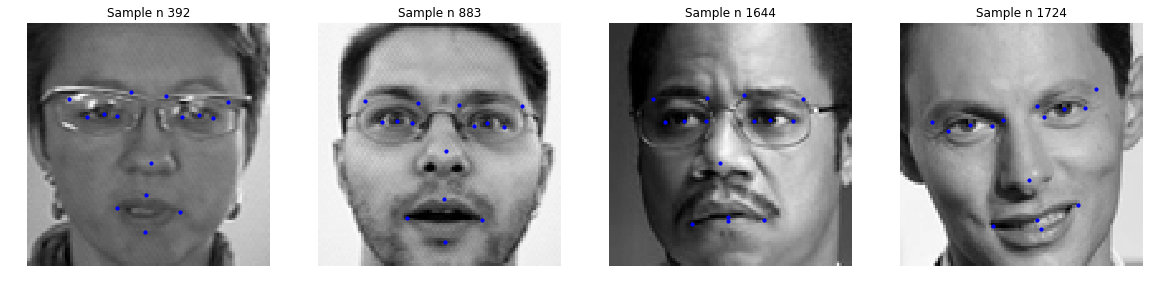

In [11]:
plot_face_Keypoints(dsets['train'])

In [12]:
nb_out = 30

In [13]:
class myconvNet(nn.Module):

    def __init__(self, image_size=(1,96,96)):
        super(myconvNet, self).__init__()  
        
        self.conv1 = nn.Conv2d(image_size[0], 24, kernel_size=5)
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(24, 36, kernel_size=5)
        self.pool2 = torch.nn.MaxPool2d(2, 2)


        self.conv3 = nn.Conv2d(36, 48, kernel_size=5)
        self.pool3 = torch.nn.MaxPool2d(2, 2)


        self.conv4 = nn.Conv2d(48, 64, kernel_size=5)
        self.pool4 = torch.nn.AvgPool2d(2, 2)
        
        feature_size = self._get_conv_output(image_size)
        
        self.fc1 = nn.Linear(feature_size, 128)    
        self.drop_dense1 = torch.nn.Dropout(0.25)

        self.fc2 = nn.Linear(128, 64)
        self.drop_dense2 = torch.nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, nb_out)

        
    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.drop_dense1(x)
        x = F.relu(self.fc2(x))
        x = self.drop_dense2(x)
        x = self.fc3(x)
        return x
    
    
    def _forward_features(self, x): 
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = self.pool3(x)
        x = F.relu(self.conv4(x))
        x = self.pool4(x)     
        return x
    
    
    def _get_conv_output(self, shape):
        bs = 1
        input = Variable(torch.rand(bs, *shape))
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size
    

In [14]:
myconvNet = myconvNet()
if use_gpu:
    myconvNet = myconvNet.cuda()

In [15]:
print(myconvNet)

myconvNet (
  (conv1): Conv2d(1, 24, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv2): Conv2d(24, 36, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv3): Conv2d(36, 48, kernel_size=(5, 5), stride=(1, 1))
  (pool3): MaxPool2d (size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv4): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1))
  (pool4): AvgPool2d (size=2, stride=2, padding=0, ceil_mode=False, count_include_pad=True)
  (fc1): Linear (256 -> 128)
  (drop_dense1): Dropout (p = 0.25)
  (fc2): Linear (128 -> 64)
  (drop_dense2): Dropout (p = 0.5)
  (fc3): Linear (64 -> 30)
)


In [16]:
def evaluate_model(loader, model, loss_fn, use_gpu = False):
    
    total_loss = 0
    for i, data in enumerate(loader):     
        inputs, labels = data['image'], data['keypoints']
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
                
        # forward pass
        outputs = model(inputs)
        
        # loss
        loss = loss_fn(outputs, labels)
        
        # metrics
        total_loss += loss.data[0]
            
    return (total_loss / i)

In [17]:
def train(model, train_loader, test_loader ,num_epochs, loss_fn, optimizer, patience  ):
    
    history_loss = []
    loss_train = []
    loss_test = []
    best_test_acc =  np.inf
    patience_count= 0
    for epoch in range(num_epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data['image'], data['keypoints']
            inputs, labels = Variable(inputs), Variable(labels)
            predict = model(inputs)
            
            loss = loss_fn(predict, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        loss_train.append(evaluate_model(train_loader, model,loss_fn) )
        loss_test.append( evaluate_model(test_loader, model,loss_fn) )
        history_loss.append(loss.data[0])
        
        print('Epoch:', epoch, ' Loss Train: ', loss_train[-1],  ' Lost Test: ', loss_test[-1])

        #Early stopping
        if(best_test_acc < loss_test[-1]):
            patience_count = 0
            best_test_acc = loss_test[-1]
            best_model = copy.deepcopy(model)

        if(patience_count > patience):
            break;

        patience_count += 1
        
        
    print('Done!')
    return history_loss, loss_train, loss_train, model 

In [18]:
loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(myconvNet.parameters()) 
optimizer =  optim.RMSprop(myconvNet.parameters(), lr=1e-3)
#lr = 0.1
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
num_epochs = 5
patience = 2

In [19]:
params = {'model' : myconvNet, 
        'train_loader':dset_loaders['train'],
         'test_loader':dset_loaders['valid'],
         'num_epochs': num_epochs,
         'loss_fn': loss_fn,
        'optimizer': optimizer, 
         'patience': patience 
         }

In [20]:
history_loss, loss_train, loss_train, model   = train(**params)

Epoch: 0  Loss Train:  0.024134651927108116  Lost Test:  0.026548822410404682
Epoch: 1  Loss Train:  0.017259973764532442  Lost Test:  0.02061023050919175
Epoch: 2  Loss Train:  0.015771432031849116  Lost Test:  0.019201141006002825
Epoch: 3  Loss Train:  0.013399169088877512  Lost Test:  0.01444235738987724
Done!


In [21]:
def predict(model, dset_loaders, use_gpu = False):

    predictions = []
    if use_gpu:
        use_gpu = torch.cuda.is_available()

    model.train(False)  # Set model to evaluate mode
    ii_n = len(dset_loaders)
    for ii, data in enumerate(dset_loaders):
        image, labels = data['image'], data['keypoints']
        if use_gpu:
            image = Variable(image.cuda())
        else:
            image = Variable(image)
        outputs = model.forward(image)
        predictions.append(outputs.data.cpu())
        print('\rpredict: {}/{}'.format(ii, ii_n - 1), end='')
    print(' ok')
    if len(predictions) > 0:
        return torch.cat(predictions, 0)

In [22]:
preds_test = predict(myconvNet, dset_loaders['test'])
preds_train = predict(myconvNet, dset_loaders['train'])

predict: 55/55 ok
predict: 66/66 ok


In [23]:
(preds_test.shape, preds_train.shape)

(torch.Size([1783, 30]), torch.Size([2140, 30]))

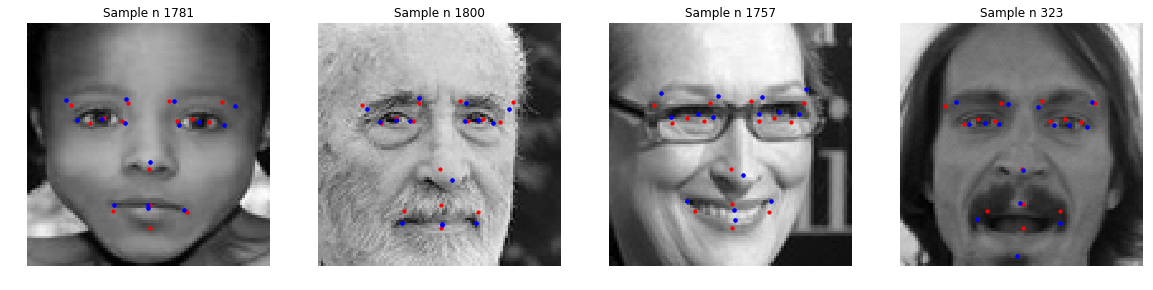

In [24]:
plot_face_Keypoints(dsets['train'],  preds_train = preds_train)

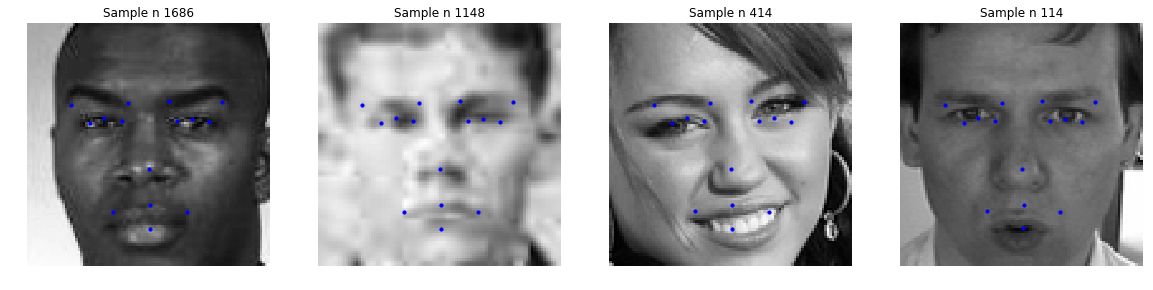

In [25]:
plot_face_Keypoints(dsets['test'], is_train= False,  preds_test = preds_test)

In [26]:
id_lookup_frame = pd.read_csv(path2data + "IdLookupTable.csv")
val_reqrd = id_lookup_frame[["ImageId", "FeatureName"]]
val_reqrd.head()

,ImageId,FeatureName
0,1,left_eye_center_x
1,1,left_eye_center_y
2,1,right_eye_center_x
3,1,right_eye_center_y
4,1,left_eye_inner_corner_x


In [50]:
y_test= preds_test.numpy() * 48  + 48
columns = dsets['train'].columns[:-1]

In [ ]:
def generate_output_submission(y_test, columns, filename = "result.csv"):
    y_res = []
    j = 0
    k = 0
    m = 0
    for i in range(1, len(y_test)+1):
        img = np.array(val_reqrd[val_reqrd["ImageId"]==i])
        if img.shape[0] == 30:
            y_res += list(y_test[i-1,:])
            j += 30
        else:
            slice_img = y_test[i-1, :]
            y_res += [slice_img[j] for j in range(30) if columns[j] in img[:, 1]]
            k += len([slice_img[j] for j in range(30) if columns[j] in img[:, 1]])
    y_res = np.array(y_res)

    
    result_dict = {
    "RowId": range(1,y_res.shape[0]+1),
    "Location": y_res
    }
    result_df = pd.DataFrame(result_dict, )
    result_df.to_csv(filename, index=False, columns=["RowId", "Location"])
    print('Done!')

In [ ]:
generate_output_submission(y_test, columns)